In [1]:
import numpy as np
import pandas as pd
import torch as torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform=transforms.Compose([transforms.ToTensor()])#transforms.compose is like pipeline it performs given list of transformations one by one.

**torchvision.datasets contains dataset divided into train_data
and test_data.Further train_data is divided into features and class labels in the form of tuple where tuple[0] has features and tuple[1] has class labels.so for the test_data.**

In [4]:
train_data=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

Files already downloaded and verified


In [5]:
test_data=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified


**Selecting only 5 classes**

In [6]:
train_image=torch.zeros(25000,3,32,32)
train_label=torch.zeros(25000)
test_image=torch.zeros(5000,3,32,32)
test_label=torch.zeros(5000)

In [7]:
i=0
for tuple in train_data:
    if(tuple[1]<5):
        train_image[i]=tuple[0]
        train_label[i]=tuple[1]
        i+=1

In [8]:
i=0
for tuple in test_data:
    if(tuple[1]<5):
        test_image[i]=tuple[0]
        test_label[i]=tuple[1]
        i+=1

In [9]:
print("train-image:",train_image.shape,"\ntrain-label:",train_label.shape,"\ntest_image:",test_image.shape,"\ntest-label:",test_label.shape)

train-image: torch.Size([25000, 3, 32, 32]) 
train-label: torch.Size([25000]) 
test_image: torch.Size([5000, 3, 32, 32]) 
test-label: torch.Size([5000])


In [13]:
train_label=train_label.type(torch.int64)
test_label=test_label.type(torch.int64)

In [14]:
label_map={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer'}

**train_data has features and label combined in tuple as train_data[0] contains both 1st image pixels and class.Further train_data[0][0] has features and train_data[0][1] has class labels.So for the test data.**

In [15]:
list=[]
for i in range(len(train_label)):
  list.append(train_label[i].item())

In [16]:
len(list)

25000

In [17]:
df=pd.DataFrame(list,columns=['class'])

In [18]:
df.shape

(25000, 1)

In [19]:
df.head(2)

,class
0,4
1,1


In [20]:
df['class'].unique()

array([4, 1, 2, 3, 0], dtype=int64)

<Axes: xlabel='class', ylabel='count'>

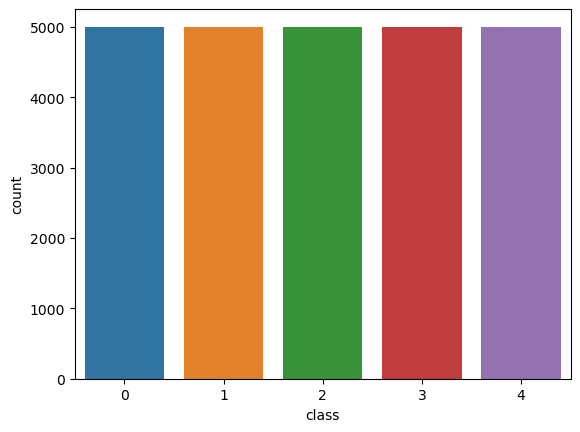

In [21]:
import seaborn as sns
sns.countplot(data=df,x='class')

**train_data has equal number of images of each class.Hence no unbalanced data set.**

In [22]:
list=[]
for i in range(len(test_data)):
  list.append(test_data[i][1])

In [23]:
df=pd.DataFrame(list,columns=['class'])
df.head(2)

,class
0,3
1,8


<Axes: xlabel='class', ylabel='count'>

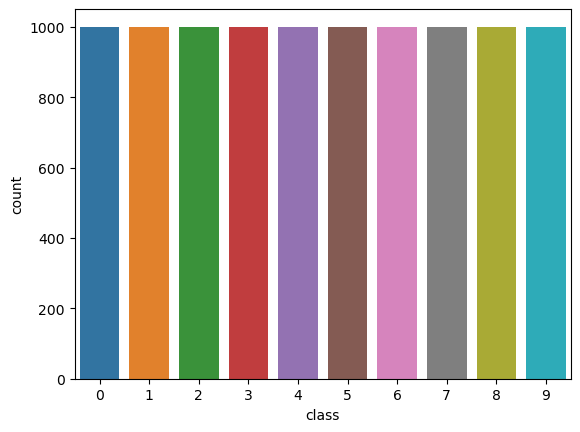

In [24]:
sns.countplot(data=df,x='class')

**test_data also has equal number of images of each class.Hence no unbalanced data set.**

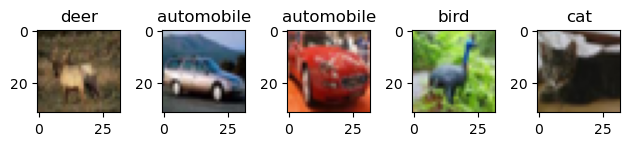

In [26]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,5)
for i in range(0,5,1):
  axs[i].imshow(train_image[i].permute(1,2,0))
##feature is storing (no_of_layer,dimension,dimension) but plt.imshow asks for(dimension,dimension,no_of_layer) that's why permute(1,2,0) brings values at 1 dimension to 0,2 to 1 and 0 to 2.
  axs[i].set_title(label_map[train_label[i].item()])
plt.tight_layout()

In [27]:
from torch.utils.data import TensorDataset

In [28]:
train_data=TensorDataset(train_image,train_label)
test_data=TensorDataset(test_image,test_label)

**Let us divide data into mini-batches**

In [29]:
from torch.utils.data import DataLoader

In [30]:
print(train_data.__len__())
print(test_data.__len__())
train_data=DataLoader(train_data,batch_size=16)
test_data=DataLoader(test_data,batch_size=16)

25000
5000


In [31]:
train_data.batch_size

16

In [32]:
train_data.__len__()

1563

In [33]:
test_data.__len__()

313

In [34]:
i=0
for feature,label in train_data:
  print(feature.shape,label)
  i+=1
  if(i==1):
    break

torch.Size([16, 3, 32, 32]) tensor([4, 1, 1, 2, 3, 4, 2, 3, 2, 4, 3, 2, 3, 4, 0, 0])


**The data is already normalized when we transformed into transforms.ToTensor() so no need to normalize the data**

**Let us build cnn architecture**

In [35]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#help(nn.Conv2d(1,3,5))

**What should we perform MaxPool or AveragePool**

In [36]:
img=next(iter(train_data))[0][1]
img.shape

torch.Size([3, 32, 32])

In [37]:
maxpool=nn.MaxPool2d(kernel_size=(2,2))
maxpool=maxpool(img)
avgpool=nn.AvgPool2d(kernel_size=(2,2))
avgpool=avgpool(img)

In [38]:
print(maxpool.shape,avgpool.shape)

torch.Size([3, 16, 16]) torch.Size([3, 16, 16])


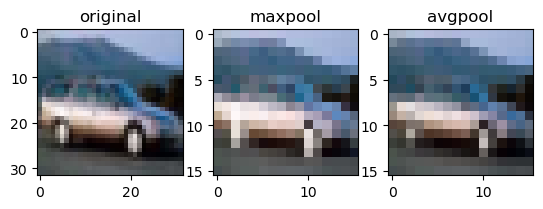

<Figure size 200x200 with 0 Axes>

In [39]:
fig,axs=plt.subplots(1,3)
fig=plt.figure(figsize=(5,5),dpi=40)
axs[0].imshow(img.permute(1,2,0),cmap='gray')
axs[0].set_title('original')
axs[1].imshow(maxpool.permute(1,2,0),cmap='gray')
axs[1].set_title('maxpool')
axs[2].imshow(avgpool.permute(1,2,0),cmap='gray')
axs[2].set_title('avgpool')
plt.tight_layout()

**Generally max pool is used to find the presence of the object and average pool is used to smoothen the image.**

In [40]:
class layer(nn.Module):
  def __init__(self,input,output):
    super().__init__()
    self.layer=nn.Linear(input,output)
  def forward(self,x,activation=True):
    if(activation):
      return F.leaky_relu(self.layer(x))
    else:
      return self.layer(x)

In [41]:
class Convolution(nn.Module):
  def __init__(self,input_channels,output_channels,kernel_y,kernel_x,stride_y,stride_x,padding_y,padding_x):
    super().__init__()
    self.convolve=nn.Conv2d(input_channels,output_channels,kernel_size=(kernel_y,kernel_x),stride=(stride_y,stride_x),padding=(padding_y,padding_x))

  def forward(self,x):
    return self.convolve(x)

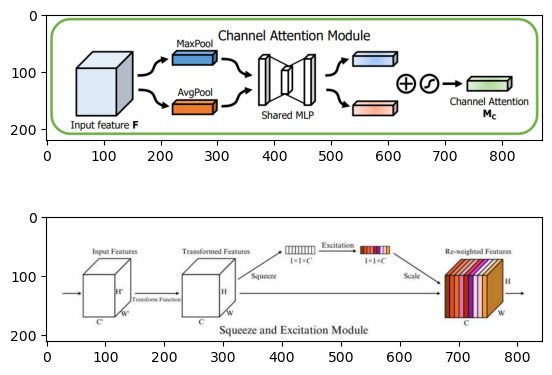

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig,axs=plt.subplots(2,1)
img1=mpimg.imread('channel_image.png')
img2=mpimg.imread('channel_attention2.png')
axs[0].imshow(img1)
axs[1].imshow(img2)
plt.show()

In [44]:
class channel_block(nn.Module):
  def __init__(self,batch_size,no_channels,kernel_y,kernel_x,r):
    super().__init__()
    self.batch_size=batch_size
    self.no_channels=no_channels
    self.maxpool=nn.MaxPool2d(kernel_size=(kernel_y,kernel_x),stride=(kernel_y,kernel_x))
    self.avgpool=nn.AvgPool2d(kernel_size=(kernel_y,kernel_x),stride=(kernel_y,kernel_x))
    self.input=layer(no_channels,no_channels//r)
    self.output=layer(no_channels//r,no_channels)
  def forward(self,x):
    pool1=self.maxpool(x)
    pool2=self.avgpool(x)
    pool1=pool1.reshape(self.batch_size,self.no_channels)
    pool2=pool2.reshape(self.batch_size,self.no_channels)
    hidden1=self.input.forward(pool1)
    output1=self.output.forward(hidden1,False)
    hidden2=self.input.forward(pool2)
    output2=self.output.forward(hidden2,False)
    output=F.sigmoid(torch.add(output1,output2))
    z=torch.zeros(x.shape,device=device)
    for i,j in enumerate(x):
      for k,l in enumerate(j):
        z[i][k]=torch.mul(l,output[i][k])
    return z

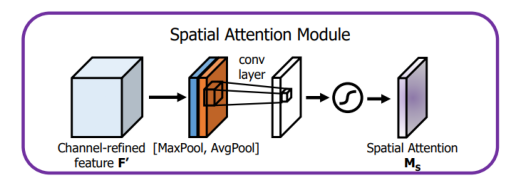

In [45]:
img = mpimg.imread('spatial_image.png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [46]:
class spatial_block(nn.Module):
  def __init__(self,no_channels):
    super().__init__()
    self.maxpool=nn.MaxPool3d(kernel_size=(no_channels,1,1),stride=(no_channels,1,1))
    self.avgpool=nn.AvgPool3d(kernel_size=(no_channels,1,1),stride=(no_channels,1,1))
    self.convolution=Convolution(2,1,5,5,1,1,2,2)
  def forward(self,x):
    pool1=self.maxpool(x)
    pool2=self.avgpool(x)
    pool_net=torch.cat([pool1,pool2],dim=1)
    output=F.sigmoid(self.convolution(pool_net))
    z=torch.zeros(x.shape,device=device)
    for i,j in enumerate(x):
      for k,l in enumerate(j):
        z[i][k]=torch.mul(l,output[i][0])
    return z


In [47]:
class Main(nn.Module):
  def __init__(self):
    super().__init__()

    ##Feature extraction layer(Convolution architecture)

    self.convolution1=Convolution(3,64,3,3,1,1,0,0)
    #3*32*32->64*30*30
    self.channel_block1=channel_block(16,64,30,30,8)
    #size does not changes in channel_block
    self.spatial_block1=spatial_block(64)
    #size does not changes in spatial_block
    self.maxpool1=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    #64*30*30->64*15*15
    self.bnorm1 = nn.BatchNorm2d(64)
    self.convolution2=Convolution(64,128,3,3,1,1,0,0)
    #64*15*15->128*13*13
    self.channel_block2=channel_block(16,128,13,13,16)
    #size does not changes in channel_block
    self.spatial_block2=spatial_block(128)
    #size does not changes in spatial_block
    self.maxpool2=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    #128*13*13->128*6*6
    self.bnorm2 = nn.BatchNorm2d(128)
    self.convolution3=Convolution(128,256,3,3,1,1,0,0)
    #128*6*6->256*4*4
    self.maxpool3=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    #128*4*4->256*2*2


    ##Fully connected layer

    self.input_layer=layer(256*2*2,128)
    self.hidden1=layer(128,64)
    self.output_layer=layer(64,10)

  def forward(self,x):
    convolve1=self.convolution1.forward(x)
    channel1=self.channel_block1.forward(convolve1)
    spatial1=self.spatial_block1.forward(channel1)
    pool1=self.maxpool1(spatial1)

    convolve2=self.convolution2.forward(self.bnorm1(pool1))
    channel2=self.channel_block2.forward(convolve2)
    spatial2=self.spatial_block2.forward(channel2)
    pool2=self.bnorm2(self.maxpool2(spatial2))

    convolve3=self.convolution3.forward(pool2)
    pool3=self.maxpool3(convolve3)

    input=pool3.reshape(16,256*2*2)
    hidden1=F.leaky_relu(self.input_layer.forward(input))
    hidden2=F.leaky_relu(self.hidden1.forward(hidden1))
    output=self.output_layer.forward(hidden2)

    return output

In [48]:
object=Main()

In [49]:
for i in object.state_dict().keys():
  print(i)

convolution1.convolve.weight
convolution1.convolve.bias
channel_block1.input.layer.weight
channel_block1.input.layer.bias
channel_block1.output.layer.weight
channel_block1.output.layer.bias
spatial_block1.convolution.convolve.weight
spatial_block1.convolution.convolve.bias
bnorm1.weight
bnorm1.bias
bnorm1.running_mean
bnorm1.running_var
bnorm1.num_batches_tracked
convolution2.convolve.weight
convolution2.convolve.bias
channel_block2.input.layer.weight
channel_block2.input.layer.bias
channel_block2.output.layer.weight
channel_block2.output.layer.bias
spatial_block2.convolution.convolve.weight
spatial_block2.convolution.convolve.bias
bnorm2.weight
bnorm2.bias
bnorm2.running_mean
bnorm2.running_var
bnorm2.num_batches_tracked
convolution3.convolve.weight
convolution3.convolve.bias
input_layer.layer.weight
input_layer.layer.bias
hidden1.layer.weight
hidden1.layer.bias
output_layer.layer.weight
output_layer.layer.bias


In [50]:
for i in object.parameters():
  print(i.shape)
  #the first matrix is weight matrix and the second matrix is bias matrix

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([8, 64])
torch.Size([8])
torch.Size([64, 8])
torch.Size([64])
torch.Size([1, 2, 5, 5])
torch.Size([1])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([8, 128])
torch.Size([8])
torch.Size([128, 8])
torch.Size([128])
torch.Size([1, 2, 5, 5])
torch.Size([1])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([128, 1024])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [51]:
object=object.to(device)

In [117]:
device

device(type='cuda', index=0)

In [53]:
object.load_state_dict(torch.load('epoch10Batch1562.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [56]:
object.train()

Main(
  (convolution1): Convolution(
    (convolve): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (channel_block1): channel_block(
    (maxpool): MaxPool2d(kernel_size=(30, 30), stride=(30, 30), padding=0, dilation=1, ceil_mode=False)
    (avgpool): AvgPool2d(kernel_size=(30, 30), stride=(30, 30), padding=0)
    (input): layer(
      (layer): Linear(in_features=64, out_features=8, bias=True)
    )
    (output): layer(
      (layer): Linear(in_features=8, out_features=64, bias=True)
    )
  )
  (spatial_block1): spatial_block(
    (maxpool): MaxPool3d(kernel_size=(64, 1, 1), stride=(64, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (avgpool): AvgPool3d(kernel_size=(64, 1, 1), stride=(64, 1, 1), padding=0)
    (convolution): Convolution(
      (convolve): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=

In [54]:
lossfun=nn.CrossEntropyLoss()

#three more optimizers are there(SGD,momentum and rmsp) but adam combines them all so we used Adam optimizer.
optimizer=torch.optim.Adam(object.parameters(),lr=0.001)
numepochs=10

losses=torch.zeros(numepochs)
for epochi in range(0,numepochs,1):

  for feature, label in train_data:

    # Clone the feature tensor to avoid inplace operations
    feature=to(device)
    yhat = object.forward(feature)

    # Compute losses
    label = label.to(device)
    loss = lossfun(yhat, label)
    losses[epochi] = loss

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [133]:
test_image=test_image.to(device)

In [57]:
object.eval()

Main(
  (convolution1): Convolution(
    (convolve): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (channel_block1): channel_block(
    (maxpool): MaxPool2d(kernel_size=(30, 30), stride=(30, 30), padding=0, dilation=1, ceil_mode=False)
    (avgpool): AvgPool2d(kernel_size=(30, 30), stride=(30, 30), padding=0)
    (input): layer(
      (layer): Linear(in_features=64, out_features=8, bias=True)
    )
    (output): layer(
      (layer): Linear(in_features=8, out_features=64, bias=True)
    )
  )
  (spatial_block1): spatial_block(
    (maxpool): MaxPool3d(kernel_size=(64, 1, 1), stride=(64, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (avgpool): AvgPool3d(kernel_size=(64, 1, 1), stride=(64, 1, 1), padding=0)
    (convolution): Convolution(
      (convolve): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=

In [58]:
prediction=[]
for index in range(0,312,1):
    pred=torch.argmax(torch.softmax(object.forward(test_image[index*16:(index+1)*16]),dim=1),dim=1)
    for i in pred:
        prediction.append(i)

In [59]:
correct=0
for i in range(len(prediction)):
    if(prediction[i]==test_label[i].detach()):
        correct+=1

In [60]:
print(correct)

3912


In [61]:
print("Accuracy",(correct/4992)*100)

Accuracy 78.36538461538461


In [62]:
from sklearn.metrics import classification_report,confusion_matrix

In [63]:
print(confusion_matrix(prediction,test_label[:4992].detach()))
print(classification_report(prediction,test_label[:4992].detach()))

[[768  35  41  47  18]
 [ 24 914  10  20   3]
 [135  16 740 103  79]
 [ 17  21  74 632  42]
 [ 53  13 134 195 858]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       909
           1       0.91      0.94      0.93       971
           2       0.74      0.69      0.71      1073
           3       0.63      0.80      0.71       786
           4       0.86      0.68      0.76      1253

    accuracy                           0.78      4992
   macro avg       0.78      0.79      0.78      4992
weighted avg       0.79      0.78      0.78      4992



In [64]:
conv1_output=object.convolution1.forward(train_image[24991])

In [65]:
conv1_output.shape

torch.Size([64, 30, 30])

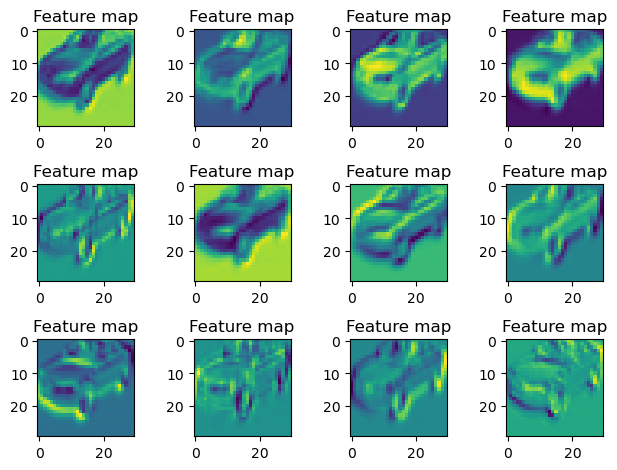

In [66]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title("Feature map")
    #plt.tight_layout()
plt.tight_layout()

In [67]:
pool1=F.max_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)
pool2=F.avg_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)

In [68]:
print(pool1.shape,pool2.shape)

torch.Size([64]) torch.Size([64])


In [69]:
channel1_attention=object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))

In [70]:
channel1_attention.shape

torch.Size([64])

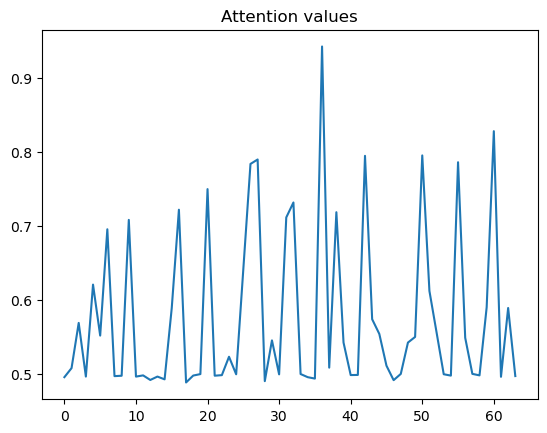

In [71]:
plt.plot(F.sigmoid(channel1_attention).detach())
plt.title('Attention values')
plt.show()

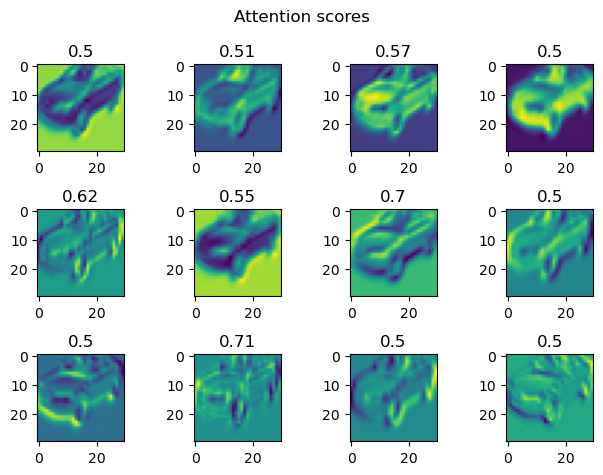

In [72]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title(round(F.sigmoid(channel1_attention[i]).item(),2))
plt.suptitle("Attention scores")
plt.tight_layout()

In [73]:
print(torch.argmax(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))),torch.argmin(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))))

tensor(36) tensor(17)


In [74]:
F.sigmoid(torch.max(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))))

tensor(0.9423, grad_fn=<SigmoidBackward0>)

In [75]:
F.sigmoid(torch.min(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))))

tensor(0.4880, grad_fn=<SigmoidBackward0>)

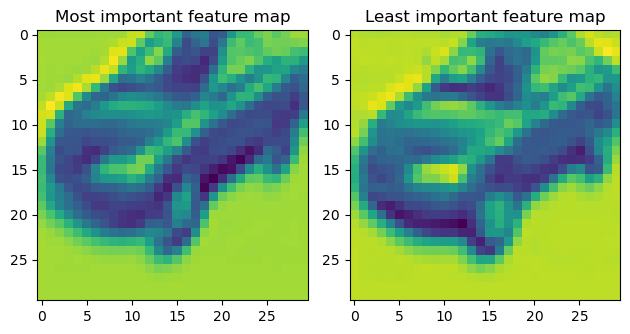

In [76]:
fig,axs=plt.subplots(1,2)
axs[0].imshow(torch.mul(0.9423,conv1_output[36]).detach())
axs[0].set_title("Most important feature map")
axs[1].imshow(torch.mul(0.4880,conv1_output[17]).detach())
axs[1].set_title("Least important feature map")
plt.tight_layout()

In [77]:
maxpool=nn.MaxPool3d(kernel_size=(64,1,1),stride=(64,1,1))
avgpool=nn.AvgPool3d(kernel_size=(64,1,1),stride=(64,1,1))

In [78]:
convolve1=object.convolution1(train_image[24990:24992])

In [79]:
convolve1.shape

torch.Size([2, 64, 30, 30])

In [80]:
spatial1_output=object.spatial_block1.convolution(torch.cat([maxpool(object.convolution1(train_image[24990:24992]))[1],avgpool(object.convolution1(train_image[24990:24992]))[1]],dim=0))

In [81]:
spatial1_output.shape

torch.Size([1, 30, 30])

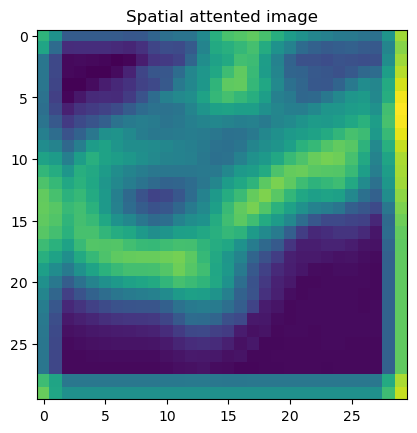

In [82]:
plt.imshow(spatial1_output.permute(1,2,0).detach())
plt.title("Spatial attented image")
plt.show()

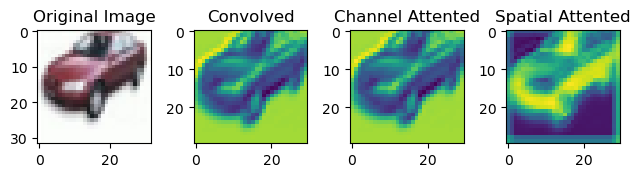

In [83]:
fig,axs=plt.subplots(1,4,width_ratios=[0.25,0.25,0.25,0.25])
axs[0].imshow(train_image[24991].permute(1,2,0).detach())
axs[0].set_title("Original Image")
axs[1].imshow(conv1_output[36].detach())
axs[1].set_title("Convolved")
plt.tight_layout()
axs[2].imshow(torch.mul(0.9423,conv1_output[36]).detach())
axs[2].set_title("Channel Attented")
plt.tight_layout()
axs[3].imshow(torch.mul(spatial1_output[0],maxpool(convolve1)[1][0]).detach())
axs[3].set_title("Spatial Attented")
plt.tight_layout()

It can be clearly seen that spatial attented one actually brightens up the important part and darkens the unimportant part so that when flattened into input layer of ann the weighted sum of these particular pixel will be zero and hence no effect on the result.

In [84]:
conv1_output=object.convolution1.forward(train_image[100])

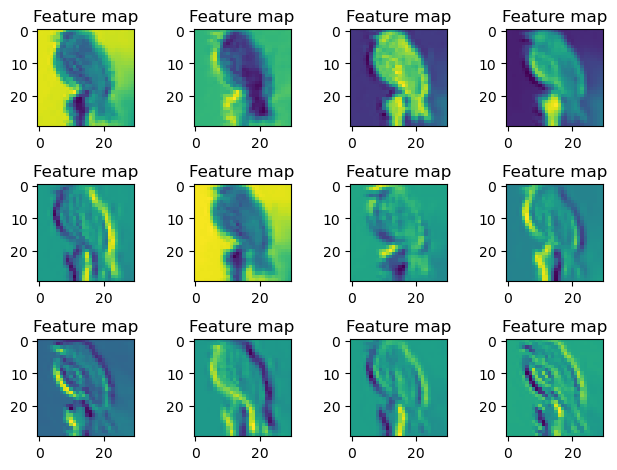

In [85]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title("Feature map")
    #plt.tight_layout()
plt.tight_layout()

In [86]:
pool1=F.max_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)
pool2=F.avg_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)

In [87]:
channel1_attention=object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))

In [88]:
channel1_attention.shape

torch.Size([64])

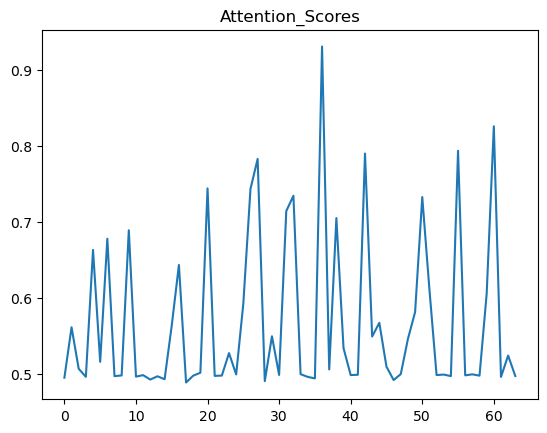

In [89]:
plt.plot(F.sigmoid(channel1_attention).detach())
plt.title("Attention_Scores")
plt.show()

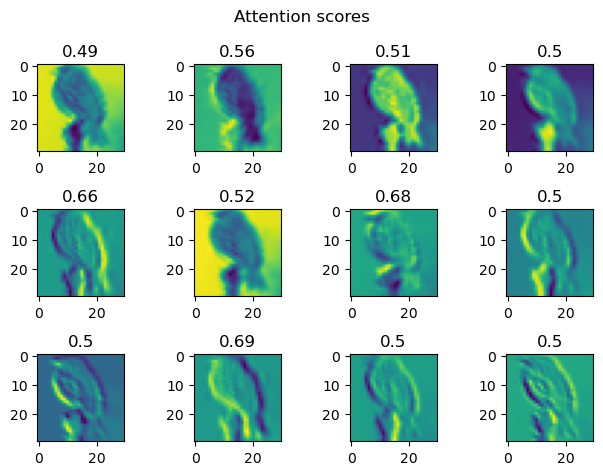

In [90]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title(round(F.sigmoid(channel1_attention[i]).item(),2))
plt.suptitle("Attention scores")
plt.tight_layout()

In [91]:
conv1_output[36].shape

torch.Size([30, 30])

Text(0.5, 1.0, 'Least Important Feature')

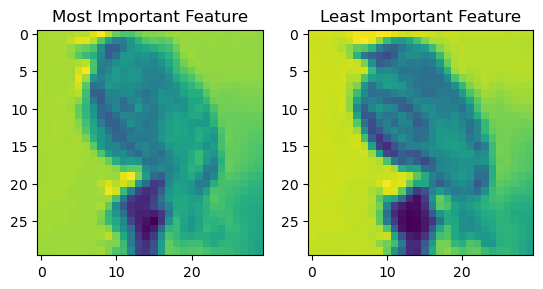

In [92]:
fig,axs=plt.subplots(1,2)
axs[0].imshow(conv1_output[torch.argmax(channel1_attention)].detach())
axs[0].set_title("Most Important Feature")
axs[1].imshow(conv1_output[torch.argmin(channel1_attention)].detach())
axs[1].set_title("Least Important Feature")

In [93]:
maxpool=nn.MaxPool3d(kernel_size=(64,1,1),stride=(64,1,1))
avgpool=nn.AvgPool3d(kernel_size=(64,1,1),stride=(64,1,1))

In [94]:
convolve1=object.convolution1(train_image[99:101])

In [95]:
spatial1_output=object.spatial_block1.convolution(torch.cat([maxpool(object.convolution1(train_image[99:101]))[1],avgpool(object.convolution1(train_image[99:101]))[1]],dim=0))

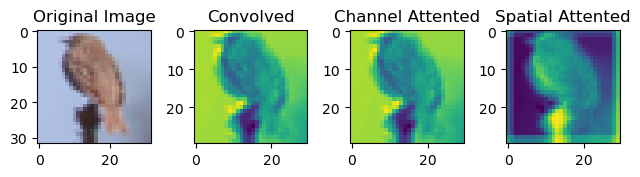

In [96]:
fig,axs=plt.subplots(1,4,width_ratios=[0.25,0.25,0.25,0.25])
axs[0].imshow(train_image[100].permute(1,2,0).detach())
axs[0].set_title("Original Image")
axs[1].imshow(conv1_output[36].detach())
axs[1].set_title("Convolved")
plt.tight_layout()
axs[2].imshow(torch.mul(F.sigmoid(torch.max(channel1_attention)),conv1_output[torch.argmax(channel1_attention)]).detach())
axs[2].set_title("Channel Attented")
plt.tight_layout()
axs[3].imshow(torch.mul(spatial1_output[0],maxpool(convolve1)[1][0]).detach())
axs[3].set_title("Spatial Attented")
plt.tight_layout()

Again we can see that spatial attentiion had blackened the background and has kept only the important part brithen.This shows the model is capable of knowing where the important part is.